In [1]:
from qiskit import *
from qiskit.visualization import plot_histogram

In [2]:
def simon_oracle(b):
    n = len(b)
    circ = QuantumCircuit(2*n, n)

    for i in range(n):
        circ.cx(i, i+n)

    # for i in range(n):
    #     if b[n-1-i] == '1':
    #         for j in range(n):
    #             if b[j] == '1':
    #                 circ.cx(i, j + n)
    #         break
    for i in range(n):
        if b[n-1-i] == '1':
            circ.cx(i, i+n)

    return circ

In [17]:
b = '1001'
n = len(b)

circ = QuantumCircuit(2*n, n)
circ.h(range(n))
circ.barrier()

circ = circ.compose(simon_oracle(b))

circ.barrier()

circ.h(range(n))

circ.measure(range(n), range(n))

In [18]:
print("the coresponding function should saticfy")
b_dex = int(b, base=2)
for num in range(2**(n-1)):
    print(f"f({num}) = f({num ^ b_dex})")

the coresponding function should saticfy
f(0) = f(9)
f(1) = f(8)
f(2) = f(11)
f(3) = f(10)
f(4) = f(13)
f(5) = f(12)
f(6) = f(15)
f(7) = f(14)


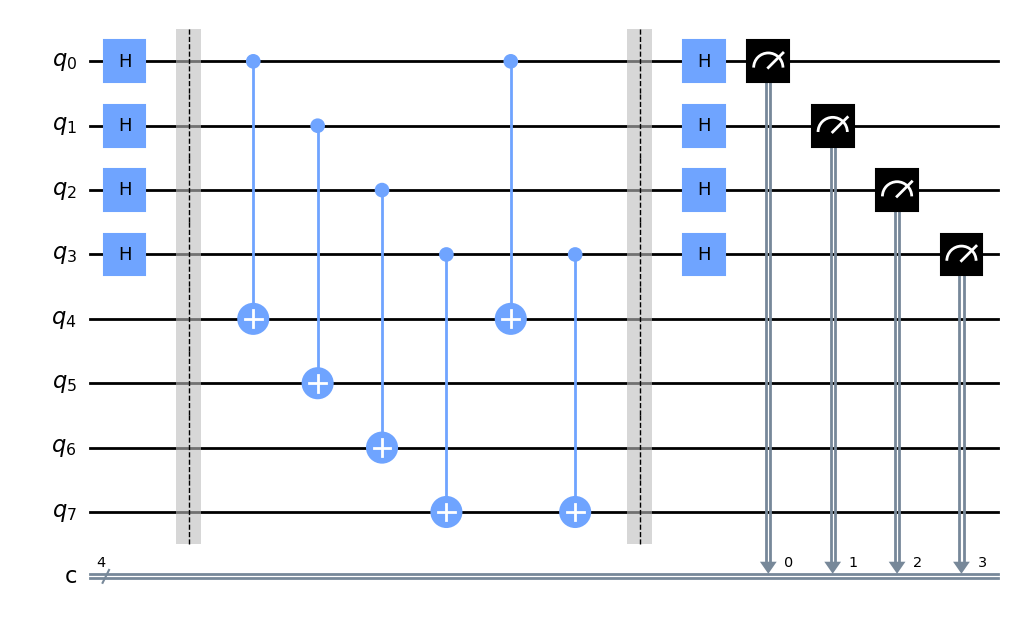

In [19]:
circ.draw('mpl')

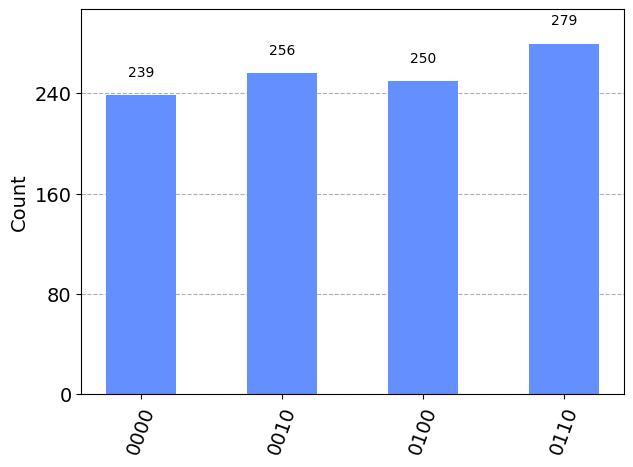

In [20]:
sim = Aer.get_backend("qasm_simulator")
result = execute(circ, backend=sim).result()

plot_histogram(result.get_counts())

In [21]:
#find b

def bdotz(b, z):
    accum = 0
    for i in range(len(b)):
        accum += int(b[i]) * int(z[i])
    return (accum % 2)

In [22]:
shots = 1024
for z in result.get_counts().keys():
    print( '{} . {} = {} (mod 2) ({:.1f}%)'.format(b, z, bdotz(b,z), result.get_counts()[z]*100/shots))

1001 . 0100 = 0 (mod 2) (24.4%)
1001 . 0110 = 0 (mod 2) (27.2%)
1001 . 0000 = 0 (mod 2) (23.3%)
1001 . 0010 = 0 (mod 2) (25.0%)


Transpiling


In [31]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.providers.fake_provider import FakeAuckland #need to change to "from qiskit_ibm_runtime.fake_provider import FakeExample" after qiskit 0.46
from qiskit.tools.visualization import circuit_drawer
fake_backend = FakeAuckland()

tran_circute = transpile(circ, fake_backend, optimization_level = 3)

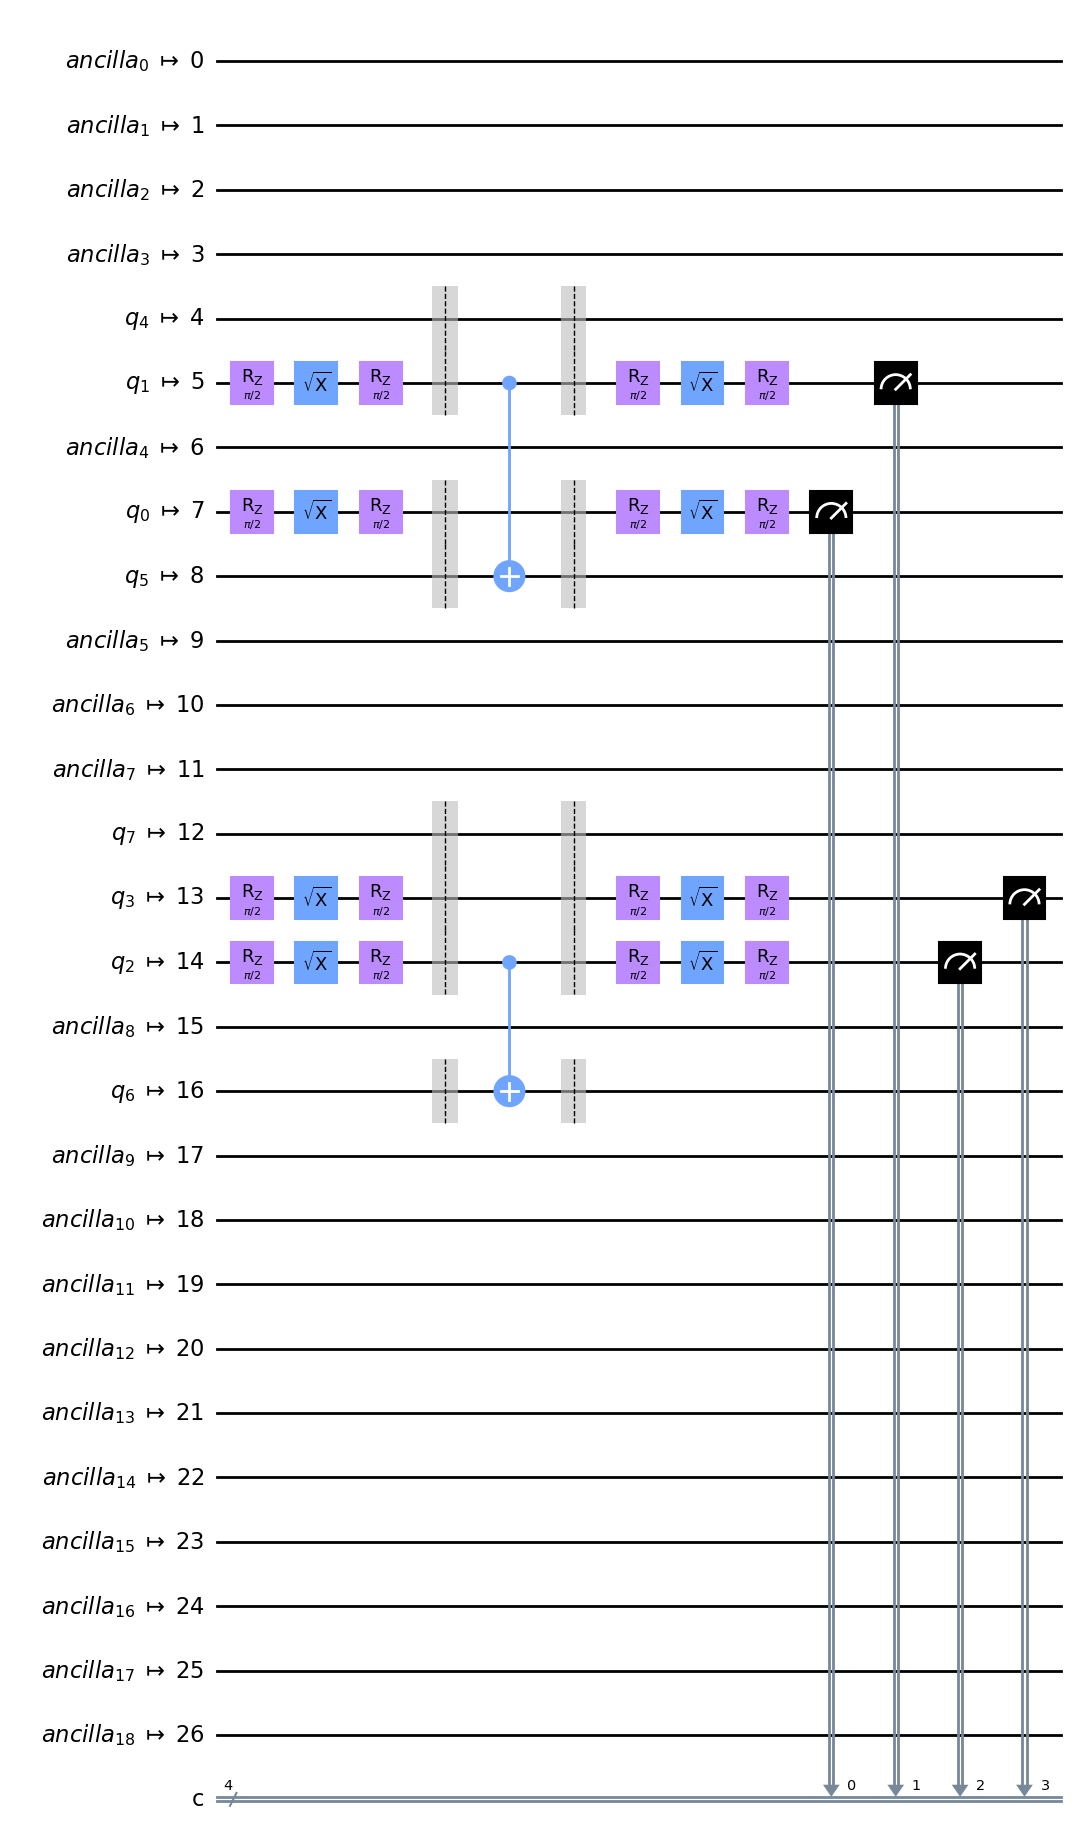

In [32]:
tran_circute.draw('mpl', fold=-1, idle_wires=True)

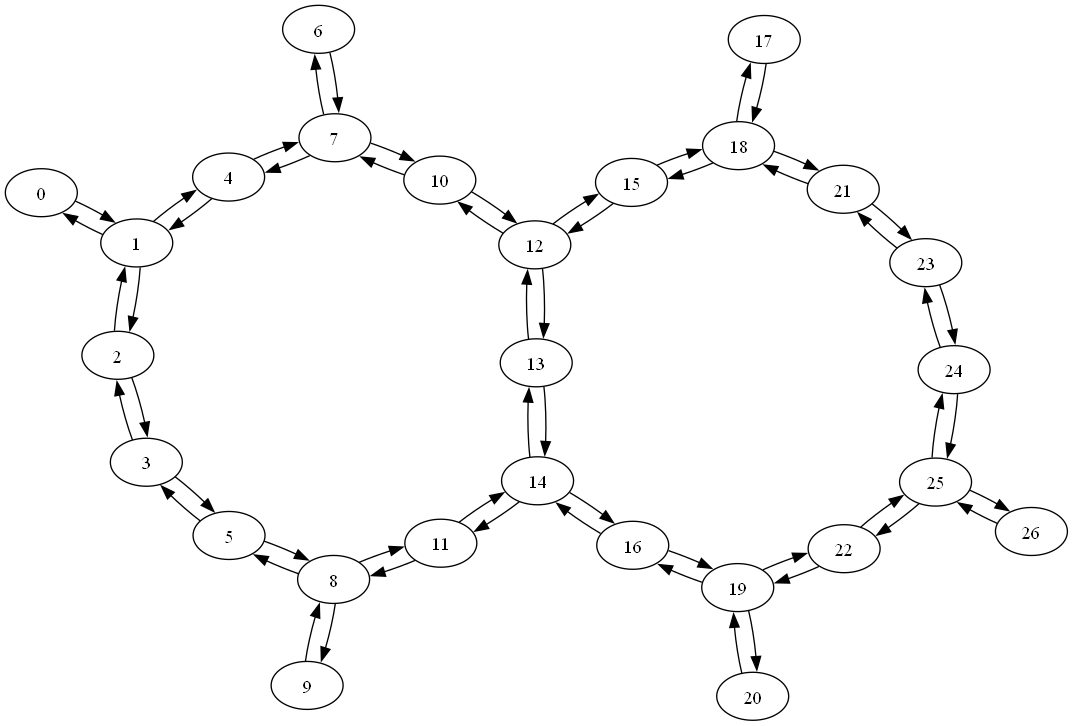

In [25]:
fake_backend.coupling_map.draw()

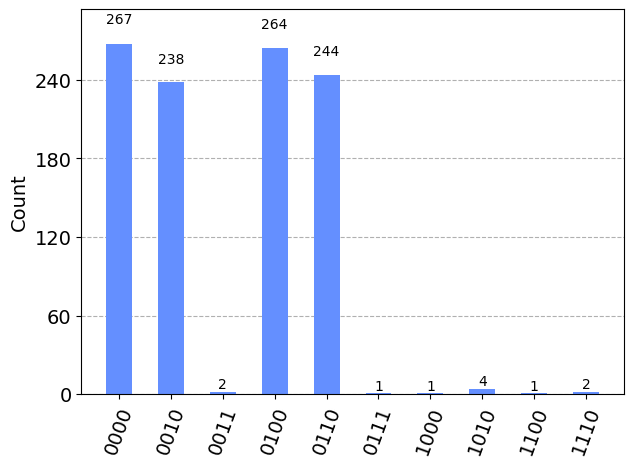

In [33]:
result = execute(tran_circute, backend=fake_backend).result()

plot_histogram(result.get_counts())

In [34]:
print(f"depth original circuit {circ.depth()}")
print(f"depth after transpiling {tran_circute.depth()}")

depth original circuit 5
depth after transpiling 8


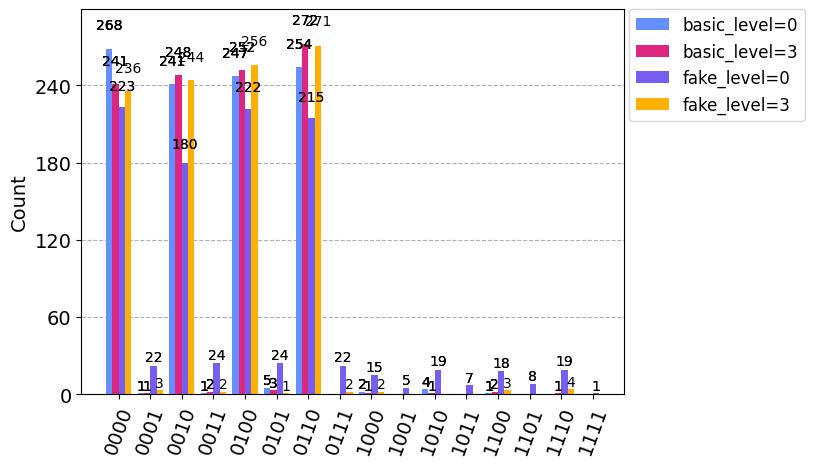

In [51]:
fake_backend = FakeAuckland()
from qiskit.transpiler.passes import RemoveBarriers

circ_no_bar = RemoveBarriers()(circ)

tran0 = transpile(circ_no_bar, backend=sim, optimization_level=0)
tran3 = transpile(circ_no_bar, backend=sim, optimization_level=3)

tran0_fake = transpile(circ_no_bar, backend=fake_backend, optimization_level=0)
tran3_fake = transpile(circ_no_bar, backend=fake_backend, optimization_level=3)

# result_basic = execute(circ_no_bar, backend=sim).result()
# result_basic_fake = execute(circ_no_bar, backend=fake_backend).result()
result_0 = execute(tran0, backend=fake_backend).result()
result_3 = execute(tran3, backend=fake_backend).result()

result_0_fake = execute(tran0_fake, backend=fake_backend).result()
result_3_fake = execute(tran3_fake, backend=fake_backend).result()

circ_no_bar.draw('mpl', fold=-1, filename="simon_basic.png")
tran0_fake.draw('mpl', fold=-1, filename="simon_level_0.png")
tran3_fake.draw('mpl', fold=-1, filename="simon_level_3.png")

plot_histogram([result_0.get_counts(), result_3.get_counts(), result_0_fake.get_counts(), result_3_fake.get_counts()], legend=['basic_level=0', "basic_level=3", "fake_level=0", "fake_level=3"])



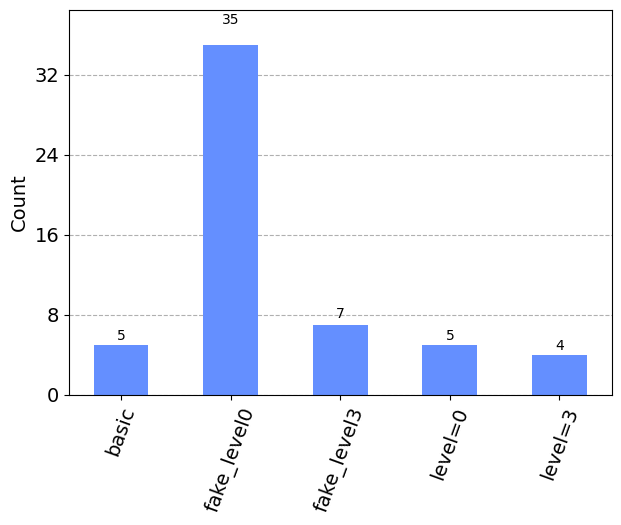

In [53]:
depth_basic = circ_no_bar.depth()

depth0 = tran0.depth()
depth3 = tran3.depth()

depth_fake0 = tran0_fake.depth()
depth_fake3 = tran3_fake.depth()

plot_histogram({"basic":depth_basic, "level=0":depth0, "level=3":depth3, "fake_level0": depth_fake0, "fake_level3":depth_fake3})